# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [182]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [183]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [184]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [185]:
ds_train = pd.read_csv("C:/Users/maico/Documents/Mestrado/dmeyf2023/datasets/competencia_02_fe.csv")
#clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
clase_train = ds_train["clase_ternaria"].map(lambda x: 1 if x == "BAJA+2" else 0)

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [ ]:
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")
#ds_bajas = ds_train.query("clase_ternaria == 'BAJA+2'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)


Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [ ]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'num_iterations': 88,
    'learning_rate': 0.0828437982941055,
    'feature_fraction': 0.998856188877586,
    'verbose': -100,
    'max_bin': 31,
    'min_data_in_leaf': 401,
    'num_leaves:': 381,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


Found `num_iterations` in params. Will use it instead of argument


In [ ]:
ds_train.shape

(4562810, 207)

Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [ ]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
0,foto_mes,247
15,mcuenta_corriente,113
170,disminuye_saldo_ahorro,88
106,ctrx_quarter,87
153,deudas,86
...,...,...
65,mcajeros_propios_descuentos,0
66,ctarjeta_visa_descuentos,0
67,mtarjeta_visa_descuentos,0
151,Visa_cadelantosefectivo,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [ ]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [ ]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 7
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.30907273993587703


,1624,7
cdescubierto_preacordado,1.00,0.061323
cliente_edad,48.00,0.060953
chomebanking_transacciones,2.00,0.051970
disminuyo_debito_automatico,0.00,0.035025
Visa_delinquency,0.00,0.034221
...,...,...
cpayroll_trx,0.00,-0.436931
disminuye_saldo_ahorro,0.00,-0.505525
mcaja_ahorro,68.25,-0.707707
deudas,0.00,-0.729793


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [ ]:
shap_bajas.mean().abs().sort_values(ascending=False)


ctrx_quarter                  0.800056
disminuye_saldo_ahorro        0.402508
cpayroll_trx                  0.376529
foto_mes                      0.367624
mcaja_ahorro                  0.337528
                                ...   
ctarjeta_visa_descuentos      0.000000
disminuye_val_inversion       0.000000
mtarjeta_visa_descuentos      0.000000
ctarjeta_master_descuentos    0.000000
cseguro_auto                  0.000000
Length: 207, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

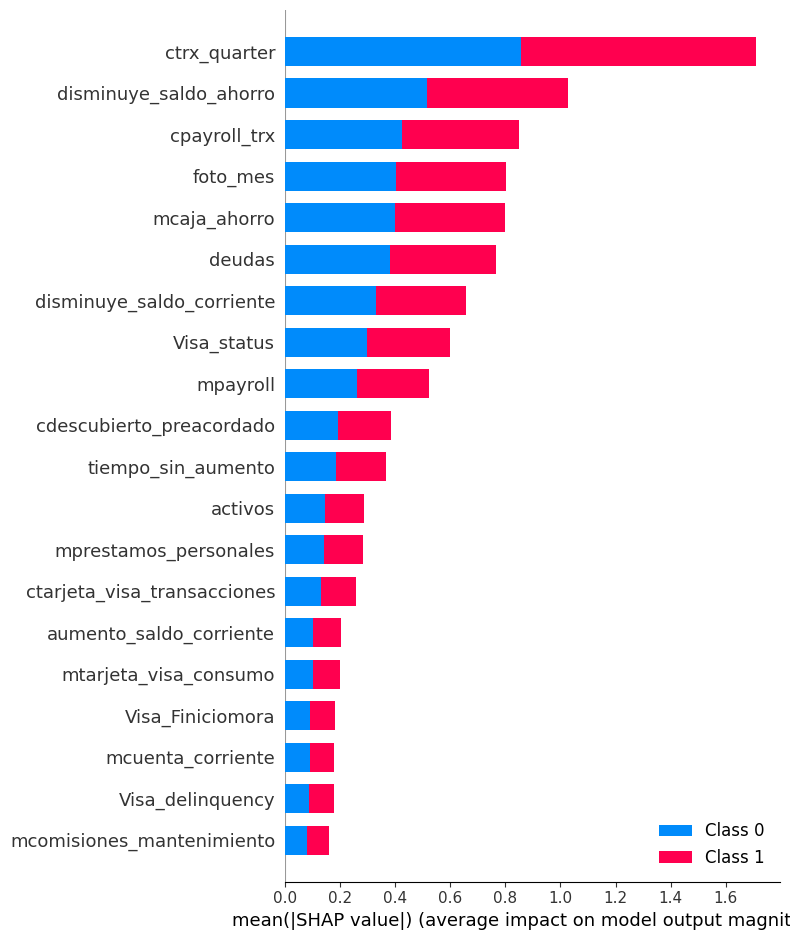

In [ ]:
shap.summary_plot(shap_values, ds_bajas)


Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

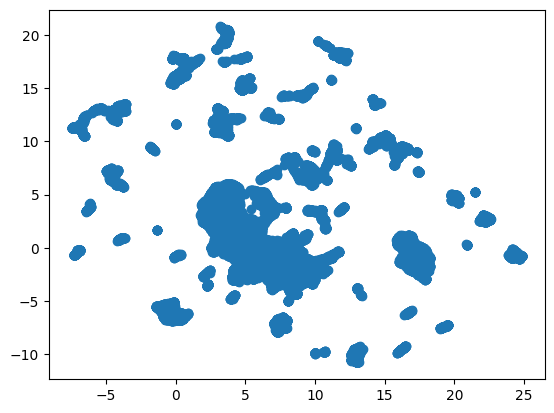

In [ ]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([10932.,  5004.,  3198.,  2037.,  1566.,  1124.,   875.,   711.,
          620.,   624.,   565.,   500.,   448.,   365.,   363.,   350.,
          312.,   285.,   341.,   355.,   384.,   384.,   359.,   415.,
          527.,   582.,   572.,   599.,   811.,  3059.]),
 array([2.16332857e-04, 3.35392991e-02, 6.68622653e-02, 1.00185231e-01,
        1.33508198e-01, 1.66831164e-01, 2.00154130e-01, 2.33477096e-01,
        2.66800062e-01, 3.00123029e-01, 3.33445995e-01, 3.66768961e-01,
        4.00091927e-01, 4.33414894e-01, 4.66737860e-01, 5.00060826e-01,
        5.33383792e-01, 5.66706758e-01, 6.00029725e-01, 6.33352691e-01,
        6.66675657e-01, 6.99998623e-01, 7.33321589e-01, 7.66644556e-01,
        7.99967522e-01, 8.33290488e-01, 8.66613454e-01, 8.99936420e-01,
        9.33259387e-01, 9.66582353e-01, 9.99905319e-01]),
 <BarContainer object of 30 artists>)

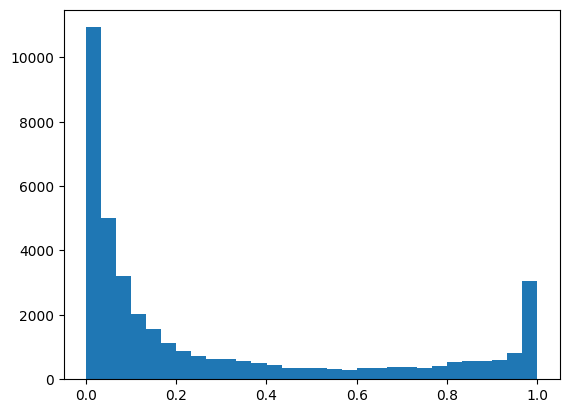

In [ ]:
plt.hist(p_bajas,bins=30)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

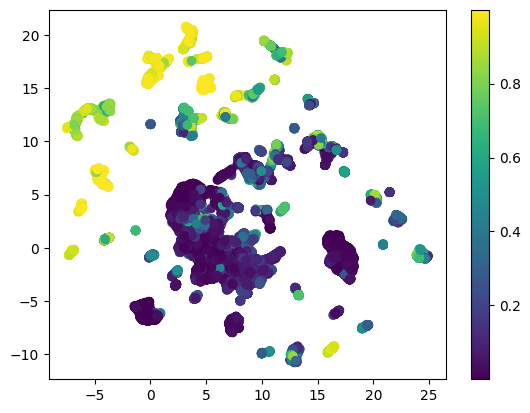

In [ ]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


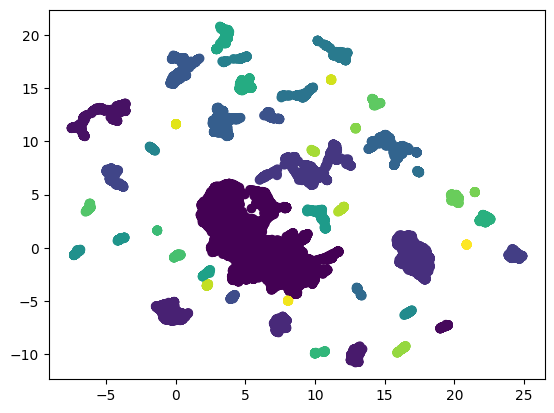

In [ ]:

hdb = DBSCAN(eps=0.75) # juegue con los parámetros 
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_)
plt.show()

Comparamos 2 clusters para ver si cambian sus variables importantes

In [ ]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

cdescubierto_preacordado      0.234123
tiempo_sin_aumento            0.183733
tiempo_sin_disminuir_cc       0.144140
aumento_saldo_ahorro          0.053976
chomebanking_transacciones    0.023208
                                ...   
deudas                       -0.506850
mcaja_ahorro                 -0.570593
disminuye_saldo_ahorro       -0.751705
disminuye_saldo_corriente    -0.849574
ctrx_quarter                 -1.232677
Length: 207, dtype: float64

In [ ]:
shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)

tiempo_sin_aumento            0.351704
disminuye_saldo_corriente     0.213842
aumento_saldo_ahorro          0.063845
chomebanking_transacciones    0.037576
Visa_fechaalta                0.025566
                                ...   
disminuye_saldo_ahorro       -0.319121
deudas                       -0.333477
cpayroll_trx                 -0.459035
mcaja_ahorro                 -0.485602
ctrx_quarter                 -0.690389
Length: 207, dtype: float64

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

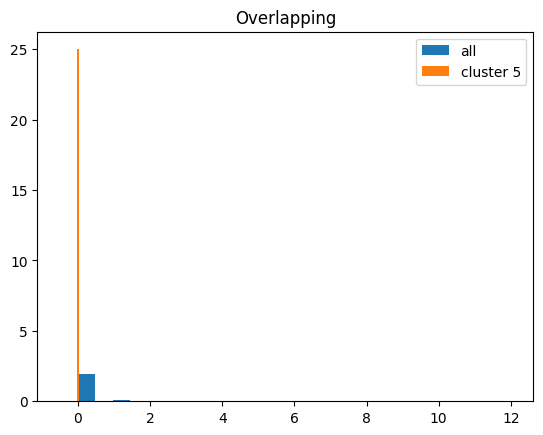

In [ ]:
plt.hist(ds_bajas.loc[:]["cpayroll_trx"], label='all', density=True, bins=25)
plt.hist(ds_bajas.loc[y.labels_ == 5]["cpayroll_trx"], label='cluster 5', density=True, bins=25)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

In [ ]:
np.unique(y.labels_).tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44]

## Random Forest distance

Veremos otro forma de llegar clusters, pero usando las distancia del Random Forest como input del embedding. Para esto, es necesario primero hacer un RF. No lo haremos con todos los datos, mantendremos todos los **BAJAS** y tan solo algunos continua.

In [ ]:
np.random.seed(17)
continua_sample = clase_train[clase_train == 0].index
bajas_1_2 = clase_train[clase_train == 1].index
#bajas_2 = ds_bajas[clase_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [ ]:
XRF = ds_bajas.iloc[rf_index]
yRF = clase_train.iloc[rf_index]

IndexError: positional indexers are out-of-bounds

In [ ]:
XRF.shape, yRF.shape

((38267, 207), (38267,))

In [ ]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat # transforma de una matriz de proximidad a una de distancia. 


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Y pasamos nuestra matriz de distancia al UMAP

In [ ]:
yRF

894        1
895        1
1100       1
1101       1
1180       1
          ..
4561420    1
4561421    1
4562477    1
4562478    1
4562641    1
Name: clase_ternaria, Length: 38267, dtype: int64

using precomputed metric; inverse_transform will be unavailable


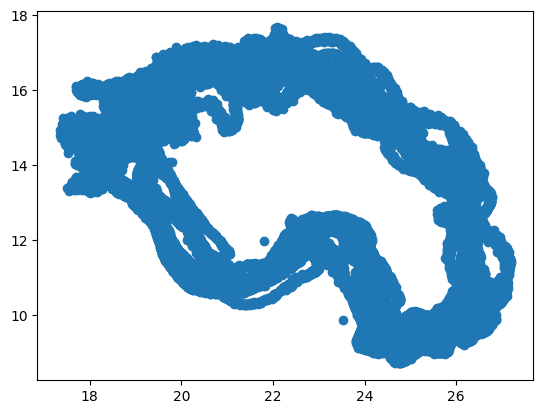

In [ ]:
embedding_rf = UMAP( # Probar parámetros
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1]) # Solo los BAJAS paso... pero no sería interesante pasar todos?

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

In [ ]:
embedding_rf[:,0].size, p_bajas.size

(38267, 18762)

ValueError: 'c' argument has 18762 elements, which is inconsistent with 'x' and 'y' with size 38267.

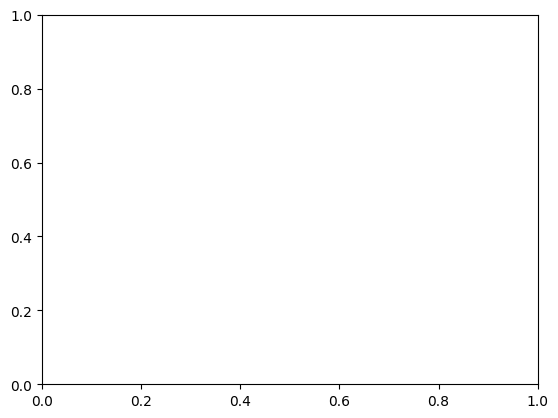

In [ ]:
sc = plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=p_bajas)
plt.colorbar(sc)
plt.show()

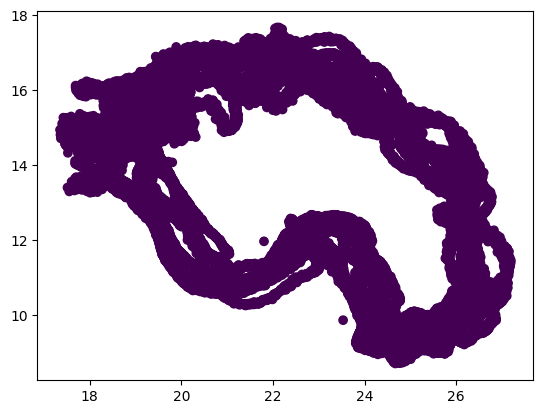

In [ ]:
hdb = DBSCAN(eps=0.75) # juegue con los parámetros 
y_rf = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y_rf.labels_)
plt.show()

In [ ]:
#listar os labels unicos
np.unique(y_rf.labels_).tolist()

[0]

In [ ]:
shap_bajas[y_rf.labels_ == 0].mean().sort_values(ascending=False).head(10), shap_bajas[y_rf.labels_ == 0].mean().sort_values(ascending=True).head(10) 

ValueError: Item wrong length 38267 instead of 18762.

In [ ]:
shap_bajas[y_rf.labels_ == 1].mean().sort_values(ascending=False).head(10), shap_bajas[y_rf.labels_ == 1].mean().sort_values(ascending=True).head(10) 

(chomebanking_transacciones            0.013967
 thomebanking                          0.009138
 mtransferencias_emitidas              0.003755
 ctarjeta_visa_debitos_automaticos     0.003285
 Visa_mconsumospesos                   0.002216
 mttarjeta_visa_debitos_automaticos    0.002137
 ctransferencias_emitidas              0.001966
 hace_transferencias                   0.001487
 aumento_saldo_ahorro                  0.001270
 uso_tar_visa_ult_mes                  0.001085
 dtype: float64,
 mcaja_ahorro                -0.727114
 ctrx_quarter                -0.593070
 cdescubierto_preacordado    -0.371110
 total_tarjetas              -0.359938
 tiempo_sin_disminuir        -0.359055
 Visa_status                 -0.350652
 disminuye_saldo_ahorro      -0.241818
 disminuye_saldo_corriente   -0.238397
 mpayroll                    -0.224087
 recibe_sueldo               -0.214775
 dtype: float64)

In [ ]:
shap_bajas[y_rf.labels_ == 2].mean().sort_values(ascending=False).head(10), shap_bajas[y_rf.labels_ == 2].mean().sort_values(ascending=True).head(10) 

(cpayroll_trx                         0.207096
 recibe_sueldo                        0.191864
 mpayroll                             0.158585
 mextraccion_autoservicio             0.004237
 internet                             0.002959
 cextraccion_autoservicio             0.001236
 ctarjeta_visa_debitos_automaticos    0.000972
 catm_trx                             0.000428
 Visa_mconsumototal                   0.000394
 disminuye_num_inversion              0.000189
 dtype: float64,
 ccaja_ahorro                  -0.227194
 foto_mes                      -0.181086
 Visa_status                   -0.138490
 Visa_mpagominimo              -0.133372
 tiempo_sin_disminuir          -0.118571
 Visa_Finiciomora              -0.116269
 total_tarjetas                -0.112619
 disminuye_saldo_corriente     -0.102178
 ctarjeta_visa_transacciones   -0.090824
 mcaja_ahorro                  -0.090647
 dtype: float64)

In [ ]:
shap_bajas[y_rf.labels_ == 3].mean().sort_values(ascending=False).head(10), shap_bajas[y_rf.labels_ == 3].mean().sort_values(ascending=True).head(10) 

(tiempo_sin_disminuir                 0.298291
 disminuye_saldo_ahorro               0.214593
 tiempo_sin_aumento                   0.085363
 aumento_saldo_ahorro                 0.035416
 chomebanking_transacciones           0.006637
 mtransferencias_emitidas             0.002713
 ctransferencias_emitidas             0.001891
 ctarjeta_visa_debitos_automaticos    0.001140
 hace_transferencias                  0.001109
 Visa_mconsumospesos                  0.000669
 dtype: float64,
 ctrx_quarter                  -0.384911
 mcaja_ahorro                  -0.343000
 mpayroll                      -0.253074
 cpayroll_trx                  -0.202964
 foto_mes                      -0.175598
 recibe_sueldo                 -0.161767
 deudas                        -0.116136
 ctarjeta_visa_transacciones   -0.105514
 activos                       -0.071876
 mtarjeta_visa_consumo         -0.071357
 dtype: float64)